# Mobile Plan Recommendation Project

## Project Description

Megaline is a mobile carrier that found many of their customers are still using outdated plans. They want to recommend users to switch to one of their newer plans: Smart or Ultra.

To help with that, I was given user behavior data, including:
- the number of calls,
- total call duration (in minutes),
- number of text messages,
- and internet usage (in MB).
- The dataset also includes the actual plan used by each customer (is_ultra, where 1 means Ultra and 0 means Smart).

The goal of this project is `to build a machine learning model` that can predict which plan (Smart or Ultra) would be more suitable for a user based on their behavior.

To evaluate the model, I’ll be using accuracy as the main metric. The goal is to achieve at least 0.75 accuracy on the test set.

In [252]:
# Importing necessary libraries
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [144]:
# Loading data
df = pd.read_csv('datasets/users_behavior.csv')

In [232]:
# Check of first 5 rows
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [147]:
df.duplicated().sum()

0

In [234]:
# We don't have null values, duplicates. So let's correct data types

In [148]:
df['calls'] = df['calls'].astype('int')

In [149]:
df['messages'] = df['messages'].astype('int')

In [150]:
df['is_ultra'].value_counts()


is_ultra
0    2229
1     985
Name: count, dtype: int64

In [151]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int32(2), int64(1)
memory usage: 100.6 KB


In [152]:
df.groupby(['is_ultra']).mean().T

is_ultra,0,1
calls,58.463437,73.392893
minutes,405.942952,511.224569
messages,33.384029,49.363452
mb_used,16208.466949,19468.823228


The average usage data shows clear behavioral differences between Smart (0) and Ultra (1) users:

- Ultra users make more calls and talk longer on average.
- They send more text messages.
- They also use significantly more internet data.

**Conclusion:**  
Ultra users are generally more active across all services. These differences make the `is_ultra` target variable predictable based on behavioral features like calls, minutes, messages, and data usage.

In [154]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Here's what we can observe from the descriptive statistics:

- The average user makes about **63 calls**, talks for **438 minutes**, sends **38 messages**, and uses around **17.2 GB** of internet per month.
- There is a **wide range** in usage, with some users making **no calls or messages**, and others making up to **244 calls**, sending **224 messages**, or using nearly **50 GB** of internet.
- The standard deviations for all features are quite high, indicating **significant variability** in user behavior.

**Conclusion:**  
User behavior is highly diverse. Some users barely use their mobile services, while others are heavy users. This variability provides useful patterns for the model to learn and distinguish between Smart and Ultra plan users.

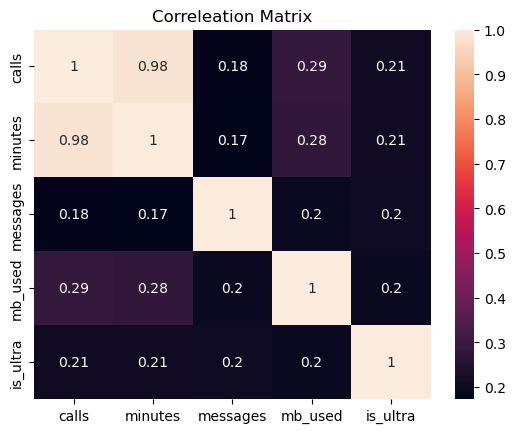

In [156]:
cm=df.corr()

sns.heatmap(cm, annot =True)
plt.title('Correleation Matrix')
plt.show()

The heatmap shows the correlation between all numerical features and the target variable `is_ultra`.

- The strongest correlation is between **calls** and **minutes** (0.98), which is expected since longer calls naturally mean more minutes.
- All other features (`messages`, `mb_used`, `calls`, `minutes`) show **weak correlations** (around 0.2) with the target `is_ultra`.
- This weak but consistent correlation across features suggests that **each feature contributes slightly** to predicting the plan type, but **no single feature is dominant**.

**Conclusion:**  
Even though individual correlations with `is_ultra` are weak, combining all features in a machine learning model can still lead to meaningful predictions.

## Split the data into training, validation, and test sets

![Splitting the data](picture1.jpg)


In [160]:
# Split 60% train, 40% remaining (which will become validation + test)
train, valid = train_test_split(df, test_size=0.4, random_state=42)
# Split remaining 40% equally into validation and test (each 20% of the original data)
valid_set, test_set = train_test_split(valid, test_size=0.5, random_state=42)

| Set       |	Share of the total |	Purpose |
|---------------------|----------|-----------|
| train     |	60%	               | Used to train the model |
| valid_set |	20%                |	Used to tune hyperparameters |
| test_set  |	20%                | Used for final model evaluation |

In [162]:
train.shape


(1928, 5)

In [163]:
valid.shape

(1286, 5)

In [164]:
display(valid_set.shape)
display(test_set.shape)

(643, 5)

(643, 5)

In [165]:
len(train)/len(df)

0.5998755444928439

## Defining the Target Column
In this classification task, our goal is to predict **which mobile plan a user is most likely to choose: Ultra or Smart.** The dataset includes a column called *is_ultra*, which clearly indicates the user's current plan for the month:

- 1 — the user is using the Ultra plan

- 0 — the user is using the Smart plan

Since this column represents the category we want our model to predict, we use is_ultra as the target variable. All other columns (such as number of calls, total call minutes, messages, and internet traffic used) are used as features, as they describe user behavior that may influence their choice of plan.

In [167]:
# Define feature columns (all except the target)
features_train = train.drop('is_ultra', axis=1)

# Define the target column
target_train = train['is_ultra']
print(features_train.shape)
print(target_train.shape)


(1928, 4)
(1928,)


In [168]:
# Define feature columns (all except the target)
features_valid = valid_set.drop('is_ultra', axis=1)

# Define the target column
target_valid = valid_set['is_ultra']

# Define feature columns (all except the target)
features_test = test_set.drop('is_ultra', axis=1)

# Define the target column
target_test = test_set['is_ultra']


## *Train models and tune hyperparameters*

For evaluating model performance more thoroughly, I calculate three key metrics:

- **Accuracy**:  
  The proportion of total correct predictions.  
  *Formula:* `(TP + TN) / (TP + TN + FP + FN)`

- **Precision** (for class 1 - Ultra):  
  Out of all predicted Ultra users, how many are actually Ultra?  
  *Formula:* `TP / (TP + FP)`  
  High precision means fewer false positives.

- **Recall** (for class 1 - Ultra):  
  Out of all actual Ultra users, how many did we correctly identify?  
  *Formula:* `TP / (TP + FN)`  
  High recall means fewer false negatives.
  


### Decision Tree

In [214]:
best_tree_model = None
best_tree_accuracy = 0

# Try different max_depth values to find the best one
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=123)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    precision = precision_score(target_valid, predictions_valid)
    recall = recall_score(target_valid, predictions_valid)
    if accuracy > best_tree_accuracy:
        best_tree_accuracy = accuracy
        best_tree_model = model
        best_tree_depth = depth
        best_tree_precision = precision
        best_tree_recall = recall
print(f'Best depth of Decision Tree: {best_tree_depth}')
print(f'Best Decision Tree accuracy: {best_tree_accuracy:.3f}')
print(f'Precision: {best_tree_precision:.3f}')
print(f'Recall: {best_tree_recall:.3f}')

Best depth of Decision Tree: 8
Best Decision Tree accuracy: 0.796
Precision: 0.780
Recall: 0.467


- The model correctly predicts ~80% of all users overall (high accuracy).
- Precision is also quite high (0.78), meaning that when the model predicts the Ultra plan, it is usually correct.
- However, recall is relatively low (0.467), meaning the model misses many actual Ultra users.

**Conclusion:**
The model is cautious when predicting the Ultra plan — it avoids false positives, but as a result, it often fails to detect real Ultra users. If the business goal is to **not miss potential Ultra subscribers**, we might want a model with higher recall.


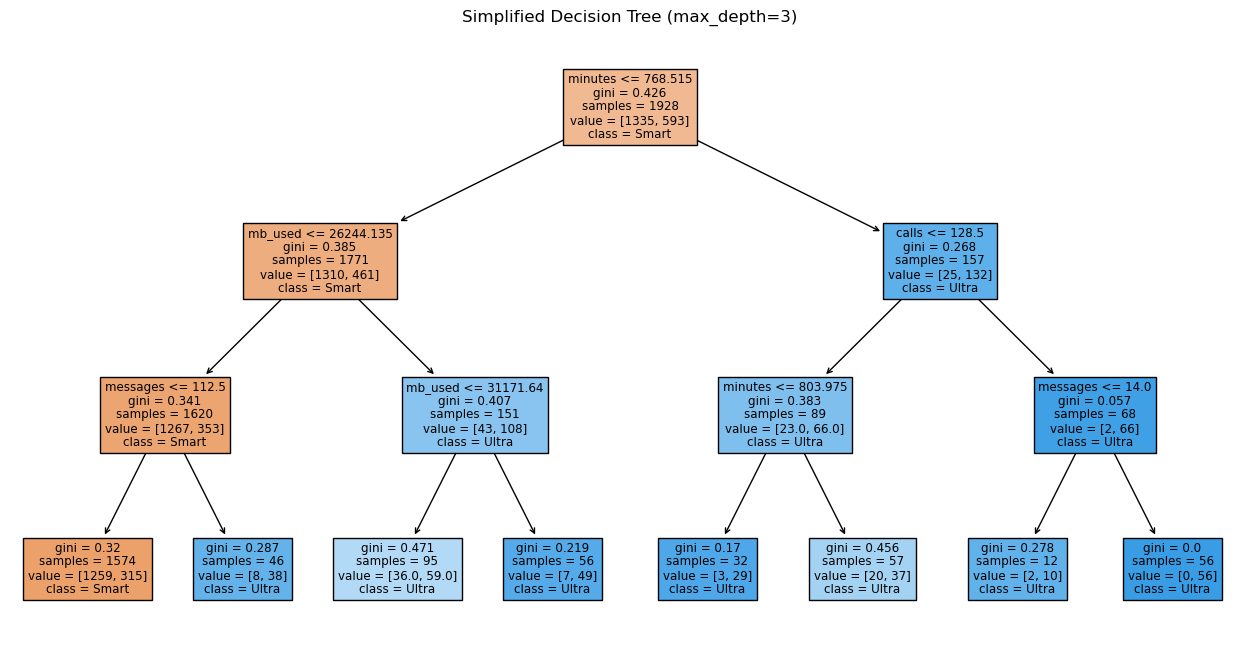

In [260]:
visual_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
visual_tree.fit(features_train, target_train)

# Visualize the smaller tree
plt.figure(figsize=(16, 8))
plot_tree(visual_tree, 
          feature_names=features.columns, 
          class_names=["Smart", "Ultra"], 
          filled=True)
plt.title("Simplified Decision Tree (max_depth=3)")
plt.show()

Although the best-performing decision tree has a maximum depth of 8, visualizing the full tree would be too complex.  
To better understand the decision-making process, I trained a smaller tree with `max_depth=3` and visualized it.

This simplified tree shows the most important early splits and helps interpret how the model separates Smart and Ultra users based on key features like:
- `minutes`
- `mb_used`
- `calls`
- `messages`

Each node in the decision tree visualization includes several key pieces of information:

- **Split condition**  
  Example: `calls <= 128.5`  
  This means that all users with 128.5 or fewer calls are included in this node.

- **gini**  
  This is the Gini impurity index — it measures how mixed the node is in terms of class labels.  
  - A value of `0` means the node is pure (only one class is present).  
  - A value close to `0.5` means the classes are mixed about evenly.  
  In our case, `gini = 0.268` indicates that most users in this node belong to the same class, but there is still some mixing.

- **samples**  
  The number of data points (users) that reached this node.  
  Example: `samples = 157` means this condition applies to 157 users.

- **value = [25, 132]**  
  This shows the number of users of each class:  
  - 25 users with the Smart plan (label 0)  
  - 132 users with the Ultra plan (label 1)

- **class = Ultra**  
  The predicted class for this node — the model predicts **Ultra** here because the majority of users in this node are Ultra users.
 than ~768 minutes and make over ~128 calls are highly likely to use the Ultra plan.  
Meanwhile, users with lower internet usage and fewer messages are more likely to stay on the Smart plan.

This kind of visualization is useful for business stakeholders who want to understand the logic behind the predictions.

## Random Forest

In [250]:
best_rf_model = None
best_rf_accuracy = 0

# Try different numbers of estimators
for n_estimators in range(1, 30):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=123)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    precision = precision_score(target_valid, predictions_valid)
    recall = recall_score(target_valid, predictions_valid)
    if accuracy > best_rf_accuracy:
        best_rf_accuracy = accuracy
        best_rf_model = model
        best_n_est_model = n_estimators
        best_rf_precision = precision
        best_rf_recall = recall

print(f'Best n_estimators Random Forest: {best_n_est_model}')
print(f'Best Random Forest accuracy: {best_rf_accuracy:.3f}')
print(f'Precision: {best_rf_precision:.3f}')
print(f'Recall: {best_rf_recall:.3f}')

Best n_estimators Random Forest: 28
Best Random Forest accuracy: 0.812
Precision: 0.775
Recall: 0.543


- This model has the highest overall accuracy (81.2%) among all tested models so far.
- Precision (0.775) is slightly lower than in the Decision Tree, but still strong.
- Recall has improved to 0.543 — the model identifies more actual Ultra users compared to the Decision Tree.

**Conclusion:**
The Random Forest model offers the best balance between accuracy, precision, and recall. It performs better in identifying Ultra plan users while maintaining solid overall performance.

## Logistic Regression

In [178]:
# Train logistic regression model
logreg_model = LogisticRegression(random_state=123, solver='liblinear')
logreg_model.fit(features_train, target_train)
predictions_valid = logreg_model.predict(features_valid)
logreg_accuracy = accuracy_score(target_valid, predictions_valid)
log_precision = precision_score(target_valid, predictions_valid)
log_recall = recall_score(target_valid, predictions_valid)
print(f'Logistic Regression accuracy: {logreg_accuracy:.3f}')
print(f'Precision: {log_precision:.3f}')
print(f'Recall: {log_recall:.3f}')


Logistic Regression accuracy: 0.720
Precision: 0.758
Recall: 0.127


- Overall accuracy is below the required threshold of 0.75.
- Precision is decent, meaning predictions of Ultra are often correct.
- However, recall is very low (0.127), which indicates that the model **fails to identify most Ultra users**.

**Conclusion:**
Logistic Regression is not suitable for this task. While it avoids false positives, it misses the majority of actual Ultra users, making it unreliable for the company’s goal of recommending plans based on user behavior.


| Model               | Accuracy | Precision | Recall |
|---------------------|----------|-----------|--------|
| Decision Tree       | 0.796    | 0.780     | 0.467  |
| Random Forest       | 0.812    | 0.775     | 0.543  |
| Logistic Regression | 0.720    | 0.758     | 0.127  |

**Conclusion:**
The **Random Forest** model performs best overall.  
It has the highest accuracy and the best balance between precision and recall, making it the most effective model for predicting user plan preferences and helping Megaline recommend the right plan.

## *Evaluate the best model on the test set*

In [182]:
# The best performing model- The Random Forest
final_model = best_rf_model  
predictions_test = final_model.predict(features_test)
final_accuracy = accuracy_score(target_test, predictions_test)

print(f'Final test set accuracy: {final_accuracy:.3f}')


Final test set accuracy: 0.799


After selecting the best model using the validation set, I evaluate its performance on the test set — data the model has never seen before.ermal.**  
As long as the test accuracy meets the required threshold (≥ 0.75) and doesn't drop significantly compared to the validation results, the model is considered stable and reliable.

## *Sanity check (baseline model)*

In [223]:
# Create and fit dummy model (always predicts most frequent class)
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(features_train, target_train)

# Predict on the test set
dummy_predictions = dummy_model.predict(features_test)

# Calculate dummy accuracy
dummy_accuracy = accuracy_score(target_test, dummy_predictions)
print(f'DummyClassifier accuracy: {dummy_accuracy:.3f}')

DummyClassifier accuracy: 0.697


Sanity Check: DummyClassifier

To confirm that our trained model is actually learning meaningful patterns rather than guessing based on class distributionIwe compared it with a baseline model — `DummyClassifier`.

- **DummyClassifier accuracy:** 0.697  
- **Random Forest test accuracy:** 0.799

**Conclusion:**  
The Random Forest model outperforms the DummyClassifier by a significant margin (≈10% higher accuracy).  
This proves that our model is not just exploiting class imbalance — it is effectively capturing real user behavior and making valuable predictions.

## Final Conclusion

In this project, I tested three classification models to predict which mobile plan (Smart or Ultra) a user is likely to choose based on their monthly behavior data.

### Model performance summary:
| Model               | Accuracy | Precision | Recall |
|---------------------|----------|-----------|--------|
| Decision Tree       | 0.796    | 0.780     | 0.467  |
| Random Forest       | 0.812    | 0.775     | 0.543  |
| Logistic Regression | 0.720    | 0.758     | 0.127  |

### Key takeaways:
- **Random Forest** performed best overall with the highest accuracy (0.812) and a balanced precision and recall, making it the most reliable model for this task.
- **Decision Tree** also performed well and is easier to interpret, but it missed more Ultra users (lower recall).
- **Logistic Regression** had the lowest recall and didn't meet the target accuracy of 0.75, making it the weakest model for this problem.

I also compared my best model to a `DummyClassifier` which simply predicts the most frequent class. The dummy model had an accuracy of **0.697**, while my Random Forest model achieved **0.799** on the test set — confirming that the model actually learned meaningful patterns.

**Final decision:**  
I recommend using the **Random Forest model** for predicting user plans. It provides strong performance and is suitable for helping Megaline recommend newer plans to their customers.